Simple BSE Demo for INFT, October 2021


Let's start by using BSE to replicate the experiment that Vernon
Smith showed results from in Chart 1 of his landmark 1962 JPE paper
-- what might plausibly be the first reported CDA experiment.
First of all let's import what we'll need.

In [1]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

import matplotlib.pyplot as plt
import numpy as np
import csv

from BSE import market_session

/bin/bash: {sys.executable}: command not found
/bin/bash: {sys.executable}: command not found


Let's say all our experiments are to last for 10 simulated minutes...

In [2]:
start_time = 0
end_time = 60 * 10

The supply and demand curves in Smith's Chart 1 are symmetric: they each involve 11 traders,
each given an assignment to trade (buy or sell) a single unit.
On both curves the minimum price was 80 and the max ws 320,
and the step-size between successive prices was always 20

In [3]:
chart1_range=(80, 320)

supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [chart1_range], 'stepmode': 'fixed'}]

Smith used periodic updating -- at the start of each "day" all traders are issued with fresh assignments
Let's do that once every 60 seconds

In [4]:
order_interval = 60
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'periodic'}

And finally let's use 11 ZIP traders on each side, buyers and sellers, because ZIP
give reasonably human-like dynamics.

In [5]:
sellers_spec = [('ZIP', 11)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

When we run a BSE market session we can alter how verbose it is, how much it tells us about what is going on, but this
can generate a *lot* of text, so let's switch that off for the time being.

In [6]:
verbose = False

Finally BSE (which was originally created before the days of Jupyter notebooks) writes files
in cv format for later anaylsis, so we need to give it a filename and a session identifier
string, and tell it to dump all data to files.

In [7]:
tdump=open('avg_balance.csv','w')
trial_id = 'smith_chart_1'
dump_all = True

And now we're ready to go... we'll run a market session, which dumps data to a file, and then we'll immediately read the file back and plot a graph of the transaction-price time-series.


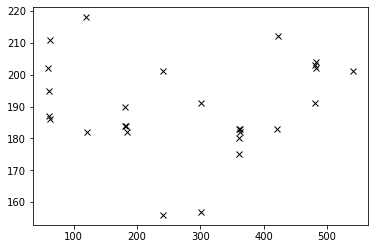

In [8]:
market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

prices_fname = trial_id + '_transactions.csv'
x = np.empty(0)
y = np.empty(0)
with open(prices_fname, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        time = float(row[1])
        price = float(row[2])
        x = np.append(x,time)
        y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

But that's just one run from a stochastic system: if we run it again we'll get a different sequence of events.
Analysis of individual runs is important, but it's also important to characterise the general behavior of the system
-- for example, we could do 10 or 50 or 100 (or more) independent and identically distributed (iid) runs, and compute summary statistics.
In the original ZIP paper (HP Labs Technical Report, 1997) multiple transaction-price time series were
summarised by showing the mean price plus and minus one standard deviation. That's a very
straghtforward way of doing things.

Let's take the code in the previous cell and wrap a loop around it, so that instead of
doing a single session, it does n_sessions.

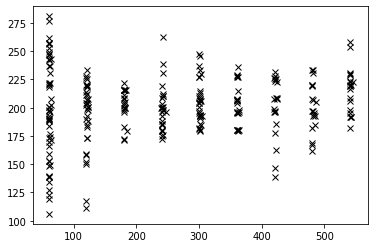

In [9]:
n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

As you can see, ZIP is not perfect (ZIP was originally written to operate in a market
that is a model of an open-outcry trading pit, rather than a LOB), but the results were getting from ZIP in BSE
are illustrative of machine trading on an automated exchange: no-one is saying ZIP is optimal!

To make things a bit more realistic, let's change the re-supply of buyer and seller assignments from periodic
to stochastic, feeding them into the market via a Poisson process, and make the schedule re-supply be on a 10-second cycle...

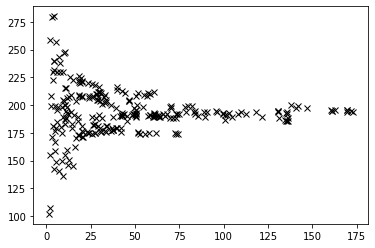

In [10]:
order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

And let's increase the number of traders from 11 on each side to
something bigger, say 40...

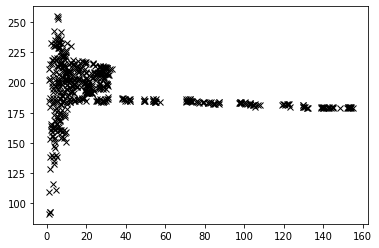

In [11]:
sellers_spec = [('ZIP', 40)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 10

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

And let's introduce some variety into the population of traders, have a mix of different strategies.

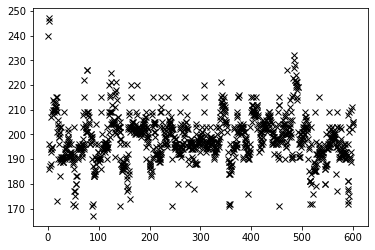

In [12]:
sellers_spec = [('ZIP', 10), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

Everything we've done so far has had a single static supply and demand schedule.
In real markets, the supply and demand schedules are constantly varying
-- often by only small amounts, but occasionally there might be large "shock" changes.

Let's introduce a shock, part-way through the session.

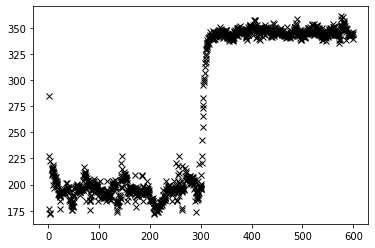

In [17]:
shocked_range = (300, 400)
shock_time = int(end_time / 2)

supply_schedule = [ {'from':0, 'to':shock_time, 'ranges':[chart1_range], 'stepmode':'fixed'},
              {'from':shock_time, 'to':end_time, 'ranges':[shocked_range], 'stepmode':'fixed'},
            ]
demand_schedule = supply_schedule

sellers_spec = [('ZIP', 10), ('ZIC', 10), ('SHVR', 10), ('GVWY', 10)]
buyers_spec = sellers_spec
traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

order_interval = 10
order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

n_sessions = 1

x = np.empty(0)
y = np.empty(0)

for sess in range(n_sessions):
    trial_id = 'smith_chart_' + str(sess)

    market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    prices_fname = trial_id + '_transactions.csv'
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

plt.plot(x, y, 'x', color='black');

That's it for now: is notebook has shown you how to set up BSE to run market sessions like Vernon Smith's first experiment in his landmark 1962 JPE paper,
and then has shown you how to alter and extend the setup to take it closer to real-world market scenarios: a heterogeneous mix of trader-types;
supply/demand assignments arriving randomly; and the supply and demand schedules altering during the session.
